# Prediciendo el Valor de Inmuebles en Bogotá
En este notebook se encontrarán con un breve repaso de limpieza de datos y aplicación de modelos predictivos de machine learning. Los datos elegidos han sido extraidos de la pagina oficial de metrocuadrado a través de tecnicas de webscraping

Para desarrollar este trabajo se requerirán de las siguientes librerias:

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
import pyreadstat as pr

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import math

In [2]:
datos = pd.read_csv('https://drive.google.com/uc?id=1jwQo5QLpdgfjqi17NV3t_nt6t8uuERgJ')

### Un breve vistazo a las variables.

Se identifica que no hay presencia de valores nulosl, sin embargo, es importante analizar las variables de tipo objeto, esto puede significar que contienen variables tipo string y que posiblemente contengan en primera instancia una secuencia de valores en diferente formato.


In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          10000 non-null  int64  
 1   mtipoinmueble       10000 non-null  object 
 2   mvalorventa         10000 non-null  int64  
 3   marea               10000 non-null  float64
 4   mnrocuartos         9993 non-null   object 
 5   mnrobanos           10000 non-null  object 
 6   mnrogarajes         9945 non-null   float64
 7   mzona               9812 non-null   object 
 8   mbarrio             9945 non-null   object 
 9   mnombrecomunbarrio  9866 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 781.4+ KB


#### Tipo de inmueble:
Se considera una variable categorica, por tanto, se procede a realizar el cast al tipo de dato.

In [4]:
datos['mtipoinmueble'] = datos.mtipoinmueble.astype('category')

#### Nombre comun barrio:
Se considera una variable categorica, por tanto, se procede a realizar el cast al tipo de dato.

In [5]:
datos['mnombrecomunbarrio'] = datos.mnombrecomunbarrio.astype('category')

#### Barrio:
Se considera una variable categorica, por tanto, se procede a realizar el cast a la variable.

In [6]:
datos['mbarrio']= datos.mbarrio.astype('category')

#### Zona:
Se considera una variable categorica, por tanto, se procede a realizar el cast a la variable.

In [7]:
datos['mzona'] = datos.mzona.astype('category')

#### Numero Cuartos:
Se considera una variable categorica, por tanto, se procede a realizar el cast a la variable, sin embargo, para esta variable es necesario realizar una ligera modificación a ciertos valores que estan siendo interpretados como Strings antes de realizar la conversión de las variables.

In [8]:
datos['mnrocuartos'] = datos.mnrocuartos.apply(lambda x: 6 if x == '5+' else x).astype(float)

#### Numero Baños:
Se considera una variable categorica, por tanto, se procede a realizar el cast a la variable, sin embargo, para esta variable es necesario realizar una ligera modificación a ciertos valores que estan siendo interpretados como Strings antes de realizar la conversión de las variables.

In [9]:
datos['mnrobanos'] = datos.mnrobanos.apply(lambda x: 6 if x == '5+' else x).astype(float)

In [10]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Unnamed: 0          10000 non-null  int64   
 1   mtipoinmueble       10000 non-null  category
 2   mvalorventa         10000 non-null  int64   
 3   marea               10000 non-null  float64 
 4   mnrocuartos         9993 non-null   float64 
 5   mnrobanos           10000 non-null  float64 
 6   mnrogarajes         9945 non-null   float64 
 7   mzona               9812 non-null   category
 8   mbarrio             9945 non-null   category
 9   mnombrecomunbarrio  9866 non-null   category
dtypes: category(4), float64(4), int64(2)
memory usage: 577.3 KB


## Visualización de los Datos
Para comprender la distrubución de los datos, 

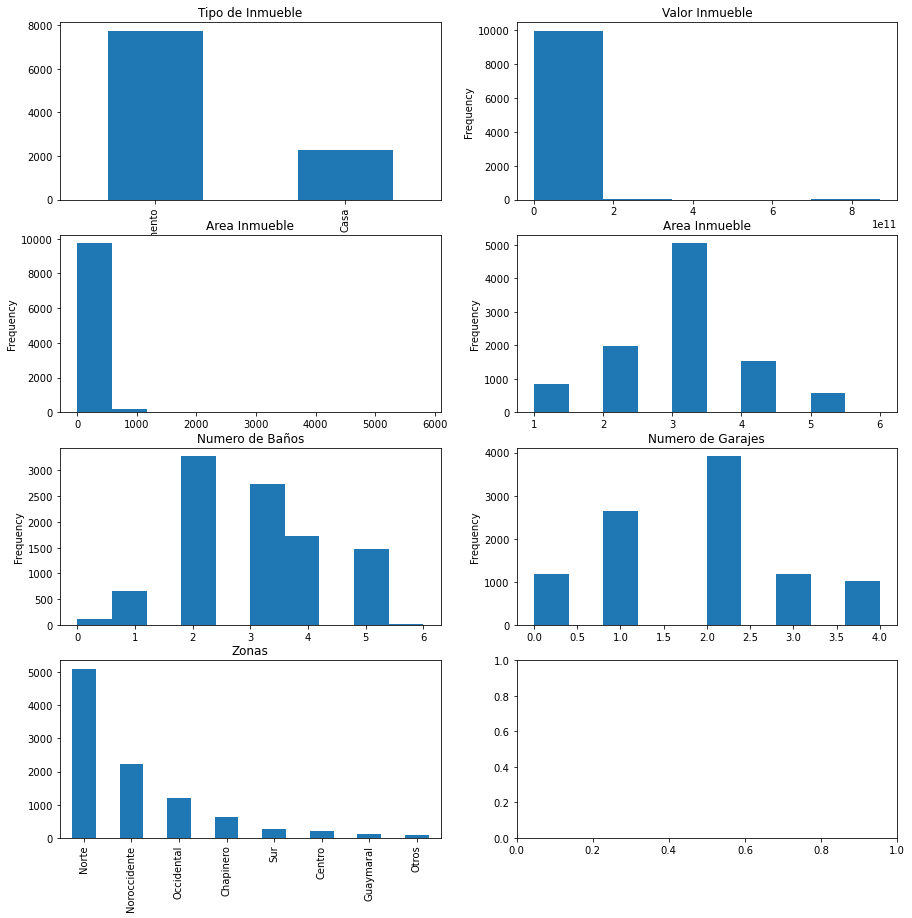

In [11]:
fig,ax = plt.subplots(4,2,figsize = (15,15))
datos.mtipoinmueble.value_counts().plot.bar(ax = ax[0,0],title = 'Tipo de Inmueble')
datos.mvalorventa.plot.hist(ax = ax[0,1],bins=5,title = 'Valor Inmueble')
datos.marea.plot.hist(ax = ax[1,0],title = 'Area Inmueble')
datos.mnrocuartos.plot.hist(ax = ax[1,1],title = 'Area Inmueble')
datos.mnrobanos.plot.hist(ax = ax[2,0],title = 'Numero de Baños')
datos.mnrogarajes.plot.hist(ax = ax[2,1],title = 'Numero de Garajes')
datos.mzona.value_counts().plot.bar(ax = ax[3,0],title = 'Zonas')
plt.show()

Es evidente que la variable area del inmueble tiene un fuerte sesgo hacia la izquierda, ocasionando que los datos no se aprecien completamente, por tanto, se decide realizar una conversión con log natural a los datos de la variable como se evidencia a continuación:

In [12]:
datos['mvalorventa_log'] = datos.mvalorventa.apply(np.log10)
datos['marea_log'] = (datos.marea + 1).apply(np.log10)

In [13]:
datos['marea'], datos['marea_log']

(0       100.0
 1        34.0
 2       157.0
 3       173.0
 4       190.0
         ...  
 9995      0.0
 9996     72.0
 9997    400.0
 9998    191.0
 9999     79.3
 Name: marea, Length: 10000, dtype: float64,
 0       2.004321
 1       1.544068
 2       2.198657
 3       2.240549
 4       2.281033
           ...   
 9995    0.000000
 9996    1.863323
 9997    2.603144
 9998    2.283301
 9999    1.904716
 Name: marea_log, Length: 10000, dtype: float64)

Sin embargo la conversión no elimina los outliers, es necesario eliminarlos realizando un filtro a la variable

Text(0.5, 0, 'log en base 10 del Area')

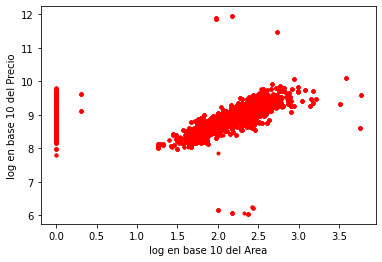

In [14]:
plt.plot(datos['marea_log'],datos['mvalorventa_log'],'r.')
plt.ylabel('log en base 10 del Precio')
plt.xlabel('log en base 10 del Area')

In [15]:
filtro = ((datos.marea_log < 0.5) | 
          (datos.marea_log > 3.5) | 
          (datos.mvalorventa_log < 7) | 
          (datos.mvalorventa_log > 11))



# El simbolo ~ significa no
datos_sin_outliers = datos[~filtro]
filtro2 = datos_sin_outliers.mvalorventa_log < 7.9
datos_sin_outliers = datos_sin_outliers[~filtro2]


### Visualización de datos sin outliers

Text(0.5, 0, 'log en base 10 del Area')

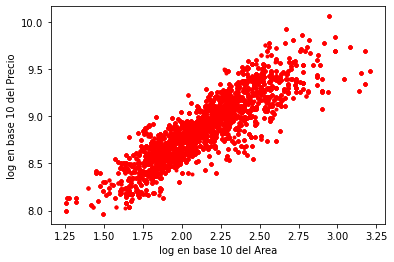

In [16]:
plt.plot(datos_sin_outliers['marea_log'], datos_sin_outliers['mvalorventa_log'], 'r.')
plt.ylabel('log en base 10 del Precio')
plt.xlabel('log en base 10 del Area')

In [17]:
df = datos_sin_outliers.drop_duplicates()

Text(0.5, 0, 'Area ($m^2$)')

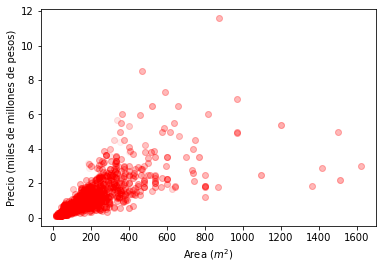

In [18]:
plt.plot(df['marea'], df['mvalorventa']/1e9, 'ro',alpha=0.05)
plt.ylabel('Precio (miles de millones de pesos)')
plt.xlabel('Area ($m^2$)')

### Manejo de valores nulos

In [19]:
# filtro3 = df.isnull()
# df[filtro3.mbarrio]
# df[filtro3.mnombrecomunbarrio]
# df[df['mnombrecomunbarrio'] == 'ARBORETTO BOSQUE RESIDENCIAL']
# df[df['mbarrio'] == 'SANTA ANA ORIENTAL']
df.isnull().sum()

Unnamed: 0              0
mtipoinmueble           0
mvalorventa             0
marea                   0
mnrocuartos             7
mnrobanos               0
mnrogarajes            55
mzona                 179
mbarrio                53
mnombrecomunbarrio    122
mvalorventa_log         0
marea_log               0
dtype: int64

In [20]:
df = df[df['mnrocuartos'].notnull()]
df = df[df['mnrogarajes'].notnull()]
df = df[df['mzona'].notnull()]
df = df[df['mnombrecomunbarrio'].notnull()]
df = df[df['mbarrio'].notnull()]

### Regresión Lineal. Estimando el valor de los inmuebles

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8591 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Unnamed: 0          8591 non-null   int64   
 1   mtipoinmueble       8591 non-null   category
 2   mvalorventa         8591 non-null   int64   
 3   marea               8591 non-null   float64 
 4   mnrocuartos         8591 non-null   float64 
 5   mnrobanos           8591 non-null   float64 
 6   mnrogarajes         8591 non-null   float64 
 7   mzona               8591 non-null   category
 8   mbarrio             8591 non-null   category
 9   mnombrecomunbarrio  8591 non-null   category
 10  mvalorventa_log     8591 non-null   float64 
 11  marea_log           8591 non-null   float64 
dtypes: category(4), float64(6), int64(2)
memory usage: 704.3 KB


#### Resultados sin partición
Rapidamente con el R cuadrado ajustado podemos suponer que el modelo explica el 83% de los datos usados como entremaniento, sin embargo, es importante saber como es el desempeño del modelo con datos que no ha observado, para ello se deben realizar una partición en los datos, así se cuenta con datos para entrenamiento y para test.

In [22]:
X = df[['marea_log','mnrogarajes','mnrobanos','mnrocuartos']]
y = df['mvalorventa_log']

reg_lin = sm.OLS(y,sm.add_constant(X)).fit() #Modelo de regresión lineal con minimos cuadrados ordinarios

print(reg_lin.summary())

                            OLS Regression Results                            
Dep. Variable:        mvalorventa_log   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                 1.079e+04
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        14:57:41   Log-Likelihood:                 4606.6
No. Observations:                8591   AIC:                            -9203.
Df Residuals:                    8586   BIC:                            -9168.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.9656      0.013    551.253      

### Partición en Datos de Entrenamiento y Test.

In [23]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

model = LinearRegression()
reg_lin_2 = model.fit(X_train,y_train)

reg_lin_2.score(X_train,y_train)

0.836355820011611

In [26]:
y_pred = reg_lin_2.predict(X_test)

In [29]:
mse = mean_squared_error(y_test,y_pred)
RMSE = math.sqrt(mse)

print(f'La Raiz del Error Cuadratico Medio es: {RMSE}')

La Raiz del Error Cuadratico Medio es: 0.14884883294709614


### ¿Que Hubiese Pasado Sin la Transformación Logaritmica?

La transformación logaritmica base 10 permite trabajar con variables numericas que difieren considerablemente en sus escalas, por tanto, esa diferencia significativa en escalas puede ocasionar deterioro en la inferencia de los resultados.

In [30]:
X_1 = df[['marea','mnrogarajes','mnrobanos','mnrocuartos']]
y_1 = df['mvalorventa']

X_train, X_test,y_train, y_test = train_test_split(X_1,y_1,test_size = 0.2, random_state = 1)

model_1 = LinearRegression()
reg_lin_3 = model_1.fit(X_train,y_train)

print(f'El R cuadrado Ajustado para este modelo es de: {reg_lin_3.score(X_train,y_train)}')


El R cuadrado Ajustado para este modelo es de: 0.60539482493735


### Clasifiación de Zonas con Arboles de decisión

A través de un modelo de arboles de decisión se lleva a cabo un proceso de clasificación de Zonas en donde se encuentran las viviendas, para ello, se considera convertir en variable Dummy el tipo de vivienda, así se puede mejorar el rendimiento del algoritmo.

In [31]:
df[['Apartamento','Casa']]  = pd.get_dummies(df['mtipoinmueble'])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8591 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Unnamed: 0          8591 non-null   int64   
 1   mtipoinmueble       8591 non-null   category
 2   mvalorventa         8591 non-null   int64   
 3   marea               8591 non-null   float64 
 4   mnrocuartos         8591 non-null   float64 
 5   mnrobanos           8591 non-null   float64 
 6   mnrogarajes         8591 non-null   float64 
 7   mzona               8591 non-null   category
 8   mbarrio             8591 non-null   category
 9   mnombrecomunbarrio  8591 non-null   category
 10  mvalorventa_log     8591 non-null   float64 
 11  marea_log           8591 non-null   float64 
 12  Apartamento         8591 non-null   uint8   
 13  Casa                8591 non-null   uint8   
dtypes: category(4), float64(6), int64(2), uint8(2)
memory usage: 721.0 KB


In [33]:
y = df['mzona']
X = df.drop(['mvalorventa','marea','mzona','mbarrio','mnombrecomunbarrio','mtipoinmueble'],axis = 1)

In [34]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =1)

In [35]:
clf = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [36]:
print(f'La precisión del algoritmo de Clasificación fue de: {metrics.accuracy_score(y_test,y_pred)}')  

La precisión del algoritmo de Clasificación fue de: 0.6079115764979639


### Mejorar la Precisión Agregando Otra Variable. 

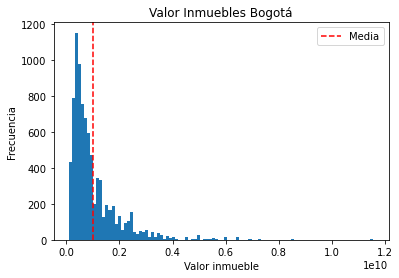

In [61]:
fig , ax = plt.subplots()
ax.hist(df['mvalorventa'],bins = 100)
ax.set(xlabel = 'Valor inmueble',ylabel='Frecuencia',title='Valor Inmuebles Bogotá')
ax.axvline(x = df['mvalorventa'].mean(),linestyle = '--',label = 'Media',color = 'r')
ax.legend()
plt.show()

<AxesSubplot:xlabel='mzona', ylabel='mvalorventa'>

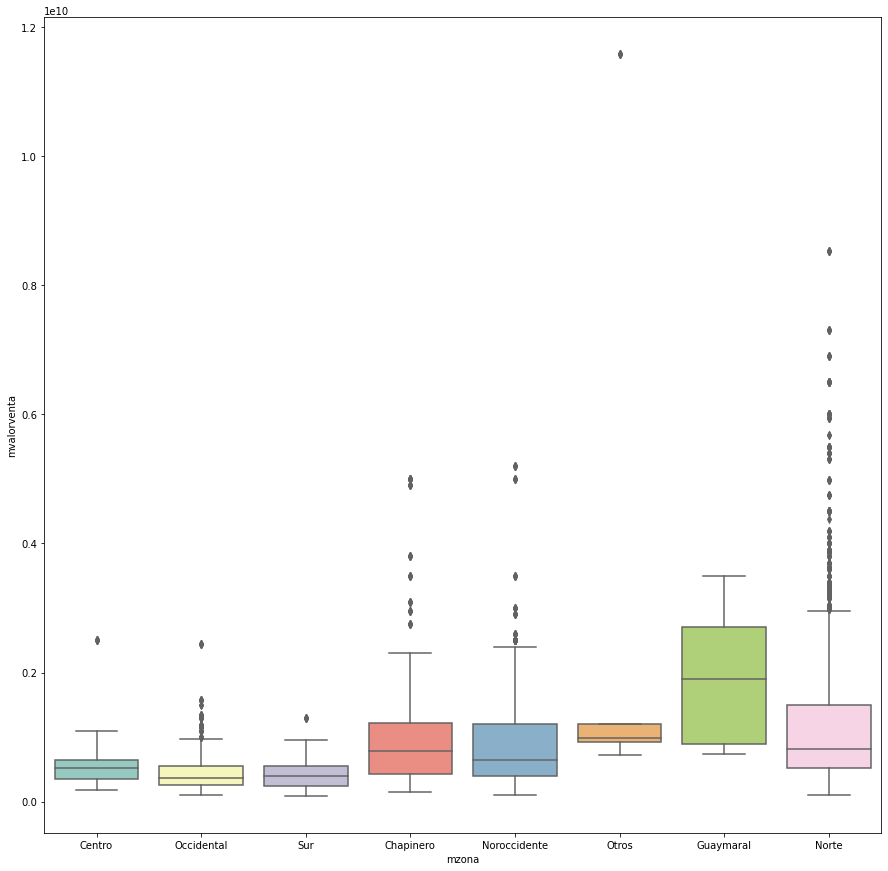

In [73]:
import seaborn as sns

fig,ax = plt.subplots(figsize=(15,15))
sns.boxplot(x = df['mzona'], y = df['mvalorventa'],palette="Set3",
           order = ['Centro','Occidental','Sur','Chapinero','Noroccidente',
                   'Otros','Guaymaral','Norte'])


In [109]:
zona_1 = df[df['mzona'].isin(['Centro','Occidental','Sur'])]
zona_2 = df[df['mzona'].isin(['Chapinero','Noroccidente','Otros'])]
zona_3 = df[df['mzona'].isin(['Guaymaral','Norte'])]

zona_1['mvalorventa'].mean()+zona_1['mvalorventa'].std(),zona_2['mvalorventa'].mean()+zona_2['mvalorventa'].std(),zona_3['mvalorventa'].mean()+zona_3['mvalorventa'].std()

(789258764.4853668, 1898994960.2334218, 2320751561.985017)

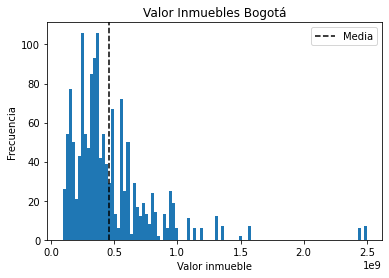

In [110]:
y = zona_1['mvalorventa']
fig , ax = plt.subplots()
ax.hist(y,bins = 100)
ax.set(xlabel = 'Valor inmueble',ylabel='Frecuencia',title='Valor Inmuebles Bogotá')

ax.axvline(x = y.mean(),linestyle = '--',label = 'Media',color = 'k')

ax.legend()
plt.show()

In [112]:
df['mvalorventa'].min(),df['mvalorventa'].max()

(92000000, 11573000000)

In [140]:
catg = ['vbajo','vmedio','valto']
val_bins = [0,789258764,1898994960,11573000000]

df['mvalorventa_ctg'] = pd.cut(x = df['mvalorventa'],bins = val_bins, labels = catg, ordered=True)